<a href="https://colab.research.google.com/github/garynico/IndoBERT-Hoax/blob/main/IndoBERT_Hoax_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoBERT for Bahasa Indonesia Hoax News Detection

### Import library

In [1]:
# Drive
from google.colab import files
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
source_folder = '/content/drive/MyDrive/TASI/GridSearch/DataImbalance'
destination_folder = '/content/drive/MyDrive/TASI/GridSearch/ModelImbalance5'

In [3]:
%cd //content/drive/MyDrive/TASI/GridSearch/DataImbalance

/content/drive/MyDrive/TASI/GridSearch/DataImbalance


In [4]:
!pip install transformers
!pip install keras.preprocessing
!pip install git+https://github.com/pytorch/text.git@v0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pytorch/text.git (to revision v0.10.0) to /tmp/pip-req-build-4q7tt_o_
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/text.git /tmp/pip-req-build-4q7tt_o_
  Running command git checkout -q 4da1de36247aa06622088e78508e0e38a4392e38
  Resolved h

In [5]:
import pandas as pd
import numpy as np
import torch


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


# Models
import torch.nn as nn

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Preliminaries

In [6]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

##Random Seed

In [8]:
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # jika menggunakan multiple GPUs
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model

In [9]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Label', label_field), ('Tokenizing_Head', text_field), ('Tokenizing_Body', text_field)]

train, valid, test = TabularDataset.splits(path=source_folder, train='train3.csv', validation='valid3.csv', test='test3.csv',
                                           format='csv', fields=fields, skip_header=True)


In [10]:
# Iterators
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [11]:
# Module
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "indobenchmark/indobert-base-p1"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    # def forward(self, headline, body, label=None):
    #     loss, text_fea = self.encoder(input_ids=body, attention_mask=(body!=PAD_INDEX), token_type_ids=(headline!=PAD_INDEX), labels=label)[:2]
    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [12]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path is None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, epoch_list):
    if save_path is None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'epoch_list': epoch_list}

    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Metrics loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['epoch_list']

## Training and Validation

In [13]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=10,
          eval_every=1,
          file_path=destination_folder,
          best_valid_loss=float("Inf"),
          patience=3):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    epoch_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()

        # evaluation step
        if epoch % eval_every == 0:
            model.eval()
            with torch.no_grad():
                # validation loop
                for (labels, title, text), _ in valid_loader:
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                    text = text.type(torch.LongTensor)
                    text = text.to(device)
                    output = model(text, labels)
                    loss, _ = output

                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / len(train_loader)
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            epoch_list.append(epoch)

            # resetting running values
            running_loss = 0.0
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, epoch_list, best_valid_loss

In [14]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model, optimizer=optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6521, Valid Loss: 0.7228
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/10], Train Loss: 0.6210, Valid Loss: 0.6529
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/10], Train Loss: 0.2738, Valid Loss: 0.2941
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/10], Train Loss: 0.1369, Valid Loss: 0.2067
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/10], Train Loss: 0.0909, Valid Loss: 0.1357
Model saved to ==> /content/drive/MyDrive/TASI/GridSear

Metrics loaded from <== /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt


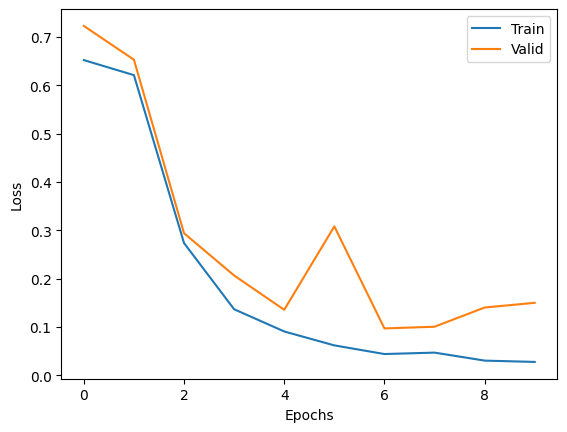

In [15]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Classification Report:
Real - Precision: 0.9633, Recall: 0.9292, F1-Score: 0.9459
Fake - Precision: 0.8632, Recall: 0.9266, F1-Score: 0.8938
Accuracy: 0.9283582089552239


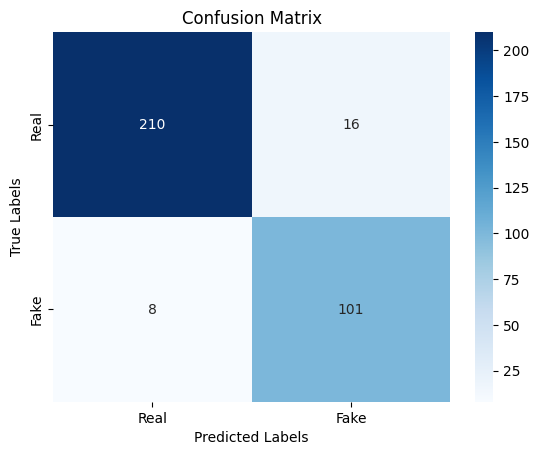

In [16]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "fake" dan label 0 menjadi "real"
    y_true = np.where(np.array(y_true) == 0, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 0, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

##Hyperparameter Tuning with Import Grid

In [17]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.4 MB/s eta 0:00:00


In [19]:
import optuna

# Define an objective function to optimize hyperparameters
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_categorical('lr', [2e-5, 3e-5, 5e-5])
    num_epochs = trial.suggest_categorical('num_epochs', [5, 6, 7, 8, 9, 10])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])

    # Define model, optimizer, and criterion
    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train model
    train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model,
                                                                          optimizer=optimizer,
                                                                          criterion=criterion,
                                                                          train_loader=train_iter,
                                                                          valid_loader=valid_iter,
                                                                          num_epochs=num_epochs,
                                                                          eval_every=1,
                                                                          file_path=destination_folder)

    # Save results
    key = f'lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}'
    results[key] = {
        'train_loss': train_loss_list[-1],
        'valid_loss': valid_loss_list,
        'epoch_list': epoch_list,
        'best_valid_loss': best_valid_loss,
        'lr': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
    }

    # Save model if best
    if best_valid_loss < results.get('best_valid_loss', float('inf')):
        results['best_valid_loss'] = best_valid_loss
        results['best_model'] = key
        torch.save(model.state_dict(), f'{destination_folder}/model_{key}.pt')

    return best_valid_loss

# Set up Optuna study with GridSampler
sampler = optuna.samplers.GridSampler({
    'lr': [2e-5, 3e-5, 5e-5],
    'num_epochs': [5, 6, 7, 8, 9, 10],
    'batch_size': [16, 32]
})
study = optuna.create_study(direction='minimize', sampler=sampler)

# Run optimization
results = {}
study.optimize(objective, n_trials=36)

# Print best model and hyperparameters
best_model = results['best_model']
best_hyperparams = results[best_model]
print('Best model:', best_model)
print('Best valid loss:', best_hyperparams['best_valid_loss'])

[I 2023-06-20 08:16:13,067] A new study created in memory with name: no-name-985cbf24-6e6c-4662-9a4a-b113f946bd4d
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.4281, Valid Loss: 0.2725
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/5], Train Loss: 0.2324, Valid Loss: 0.2335
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/5], Train Loss: 0.1483, Valid Loss: 0.2297
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/5], Train Loss: 0.0989, Valid Loss: 0.2649
Epoch [5/5], Train Loss: 0.0576, Valid Loss: 0.3111
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


[I 2023-06-20 08:18:04,225] Trial 0 finished with value: 0.22972964235980595 and parameters: {'lr': 5e-05, 'num_epochs': 5, 'batch_size': 32}. Best is trial 0 with value: 0.22972964235980595.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6660, Valid Loss: 0.6480
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/5], Train Loss: 0.6759, Valid Loss: 0.6827
Epoch [3/5], Train Loss: 0.5480, Valid Loss: 0.2730
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/5], Train Loss: 0.2011, Valid Loss: 0.1396
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/5], Train Loss: 0.1358, Valid Loss: 0.1893
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


[I 2023-06-20 08:19:57,210] Trial 1 finished with value: 0.13960315340331622 and parameters: {'lr': 2e-05, 'num_epochs': 5, 'batch_size': 32}. Best is trial 1 with value: 0.13960315340331622.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.5519, Valid Loss: 0.3763
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/5], Train Loss: 0.3421, Valid Loss: 0.1895
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/5], Train Loss: 0.1833, Valid Loss: 0.1560
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/5], Train Loss: 0.1132, Valid Loss: 0.1872
Epoch [5/5], Train Loss: 0.0673, Valid Loss: 0.1491


[I 2023-06-20 08:21:46,282] Trial 2 finished with value: 0.14907631758666998 and parameters: {'lr': 3e-05, 'num_epochs': 5, 'batch_size': 32}. Best is trial 1 with value: 0.13960315340331622.


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6422, Valid Loss: 0.6383
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/7], Train Loss: 0.4165, Valid Loss: 0.2546
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/7], Train Loss: 0.2175, Valid Loss: 0.4191
Epoch [4/7], Train Loss: 0.0835, Valid Loss: 0.2474
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/7], Train Loss: 0.0945, Valid Loss: 0.2800
Epoch [6/7], Train Loss: 0.0424, Valid Loss: 0.1931
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt


[I 2023-06-20 08:24:15,081] Trial 3 finished with value: 0.19308663342547203 and parameters: {'lr': 3e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 1 with value: 0.13960315340331622.


Epoch [7/7], Train Loss: 0.0265, Valid Loss: 0.3652
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6747, Valid Loss: 0.6538
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/9], Train Loss: 0.6894, Valid Loss: 0.6587
Epoch [3/9], Train Loss: 0.6787, Valid Loss: 0.6672
Epoch [4/9], Train Loss: 0.7166, Valid Loss: 0.6900
Epoch [5/9], Train Loss: 0.6978, Valid Loss: 0.6761
Epoch [6/9], Train Loss: 0.6954, Valid Loss: 0.7072
Epoch [7/9], Train Loss: 0.7229, Valid Loss: 0.6862
Epoch [8/9], Train Loss: 0.6840, Valid Loss: 0.7027


[I 2023-06-20 08:27:16,378] Trial 4 finished with value: 0.6537607099328723 and parameters: {'lr': 3e-05, 'num_epochs': 9, 'batch_size': 16}. Best is trial 1 with value: 0.13960315340331622.


Epoch [9/9], Train Loss: 0.6916, Valid Loss: 0.7812
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6559, Valid Loss: 0.6158
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/5], Train Loss: 0.3208, Valid Loss: 0.3257
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/5], Train Loss: 0.1612, Valid Loss: 0.4034
Epoch [4/5], Train Loss: 0.0883, Valid Loss: 0.1667
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt


[I 2023-06-20 08:29:07,294] Trial 5 finished with value: 0.16667932800815574 and parameters: {'lr': 5e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 1 with value: 0.13960315340331622.


Epoch [5/5], Train Loss: 0.0540, Valid Loss: 0.7641
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6223, Valid Loss: 0.4548
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/10], Train Loss: 0.3171, Valid Loss: 0.2242
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/10], Train Loss: 0.1675, Valid Loss: 0.1833
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/10], Train Loss: 0.1205, Valid Loss: 0.1347
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/10], Train Loss: 0.0636, Valid Loss: 0.1731
Epoch [6/10], Train Loss: 0.0255, Valid Loss: 0.2093
Ep

[I 2023-06-20 08:32:37,852] Trial 6 finished with value: 0.13472771321955537 and parameters: {'lr': 3e-05, 'num_epochs': 10, 'batch_size': 16}. Best is trial 6 with value: 0.13472771321955537.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6642, Valid Loss: 0.6272
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/10], Train Loss: 0.4517, Valid Loss: 0.2375
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/10], Train Loss: 0.2217, Valid Loss: 0.3100
Epoch [4/10], Train Loss: 0.1677, Valid Loss: 0.1928
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/10], Train Loss: 0.0694, Valid Loss: 0.2496
Epoch [6/10], Train Loss: 0.0466, Valid Loss: 0.3025
Epoch [7/10], Train Loss: 0.0269, Valid Loss: 0.2379
Epoch [8/10], Train Loss: 0.0260, Valid Loss: 0.3182
Epoch [9/10], Train Loss: 0.0280, Valid Loss: 0.3585


[I 2023-06-20 08:36:03,996] Trial 7 finished with value: 0.19278895622119308 and parameters: {'lr': 5e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 6 with value: 0.13472771321955537.


Epoch [10/10], Train Loss: 0.0246, Valid Loss: 0.2587
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6294, Valid Loss: 0.5810
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/7], Train Loss: 0.2865, Valid Loss: 0.3281
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/7], Train Loss: 0.1868, Valid Loss: 0.3055
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/7], Train Loss: 0.1168, Valid Loss: 0.3485
Epoch [5/7], Train Loss: 0.0556, Valid Loss: 0.2625
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [6/7], Train Loss: 0.0298, Valid Loss: 0.2413
Model sa

[I 2023-06-20 08:38:36,843] Trial 8 finished with value: 0.19430919633097282 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 6 with value: 0.13472771321955537.


Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6803, Valid Loss: 0.6459
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/7], Train Loss: 0.6848, Valid Loss: 0.6756
Epoch [3/7], Train Loss: 0.6921, Valid Loss: 0.7301
Epoch [4/7], Train Loss: 0.6702, Valid Loss: 0.6799
Epoch [5/7], Train Loss: 0.6719, Valid Loss: 0.6680
Epoch [6/7], Train Loss: 0.6961, Valid Loss: 0.6761


[I 2023-06-20 08:40:59,731] Trial 9 finished with value: 0.6459149100950786 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 6 with value: 0.13472771321955537.


Epoch [7/7], Train Loss: 0.6560, Valid Loss: 0.7646
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6429, Valid Loss: 0.6308
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/8], Train Loss: 0.6421, Valid Loss: 0.5796
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/8], Train Loss: 0.4533, Valid Loss: 0.5236
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/8], Train Loss: 0.2269, Valid Loss: 0.5359
Epoch [5/8], Train Loss: 0.1097, Valid Loss: 0.4865
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [6/8], Train Loss: 0.0754, Valid Loss: 0.2032
Model sa

[I 2023-06-20 08:43:50,741] Trial 10 finished with value: 0.1712250148910763 and parameters: {'lr': 5e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 6 with value: 0.13472771321955537.


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6393, Valid Loss: 0.5927
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/6], Train Loss: 0.3234, Valid Loss: 0.1712
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/6], Train Loss: 0.1844, Valid Loss: 0.2704
Epoch [4/6], Train Loss: 0.1292, Valid Loss: 0.1533
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/6], Train Loss: 0.0707, Valid Loss: 0.1327
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [6/6], Train Loss: 0.0288, Valid Loss: 0.1520
Metrics 

[I 2023-06-20 08:46:01,365] Trial 11 finished with value: 0.13269521838187107 and parameters: {'lr': 3e-05, 'num_epochs': 6, 'batch_size': 16}. Best is trial 11 with value: 0.13269521838187107.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6608, Valid Loss: 0.6721
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/10], Train Loss: 0.7054, Valid Loss: 0.6632
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/10], Train Loss: 0.5801, Valid Loss: 0.4339
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/10], Train Loss: 0.3039, Valid Loss: 0.2931
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/10], Train Loss: 0.2143, Valid Loss: 0.4195
Epoch [6/10], Train Loss: 0.1947, Valid Loss: 0.8516
Ep

[I 2023-06-20 08:49:33,272] Trial 12 finished with value: 0.24046081008522638 and parameters: {'lr': 3e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 11 with value: 0.13269521838187107.


Epoch [10/10], Train Loss: 0.0712, Valid Loss: 0.6705
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6673, Valid Loss: 0.6769
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/8], Train Loss: 0.7039, Valid Loss: 0.6775
Epoch [3/8], Train Loss: 0.6579, Valid Loss: 0.4958
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/8], Train Loss: 0.3189, Valid Loss: 0.2318
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/8], Train Loss: 0.1817, Valid Loss: 0.2127
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [6/8], Train Loss: 0.1177, Valid Loss: 0.1777
Model sa

[I 2023-06-20 08:52:25,535] Trial 13 finished with value: 0.15454922776137078 and parameters: {'lr': 3e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 11 with value: 0.13269521838187107.


Epoch [8/8], Train Loss: 0.0551, Valid Loss: 0.2143
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6868, Valid Loss: 0.6413
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/10], Train Loss: 0.5702, Valid Loss: 0.4487
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/10], Train Loss: 0.3095, Valid Loss: 0.2618
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/10], Train Loss: 0.1816, Valid Loss: 0.2427
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/10], Train Loss: 0.0953, Valid Loss: 0.2517
Epoch [6/10], Train Loss: 0.0722, Valid Loss: 0.3430
Ep

[I 2023-06-20 08:55:54,789] Trial 14 finished with value: 0.2427081445764218 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 16}. Best is trial 11 with value: 0.13269521838187107.


Epoch [10/10], Train Loss: 0.0177, Valid Loss: 0.4745
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6658, Valid Loss: 0.6838
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/6], Train Loss: 0.6605, Valid Loss: 0.6971
Epoch [3/6], Train Loss: 0.6746, Valid Loss: 0.7157
Epoch [4/6], Train Loss: 0.6488, Valid Loss: 0.6656
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/6], Train Loss: 0.7353, Valid Loss: 0.6695


[I 2023-06-20 08:57:59,249] Trial 15 finished with value: 0.6656487328665597 and parameters: {'lr': 5e-05, 'num_epochs': 6, 'batch_size': 16}. Best is trial 11 with value: 0.13269521838187107.


Epoch [6/6], Train Loss: 0.7207, Valid Loss: 0.6961
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6852, Valid Loss: 0.6702
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/10], Train Loss: 0.6973, Valid Loss: 0.6884
Epoch [3/10], Train Loss: 0.6108, Valid Loss: 0.5822
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/10], Train Loss: 0.2584, Valid Loss: 0.2373
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/10], Train Loss: 0.1494, Valid Loss: 0.2574
Epoch [6/10], Train Loss: 0.0757, Valid Loss: 0.2011
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Ep

[I 2023-06-20 09:01:34,022] Trial 16 finished with value: 0.11967409578418094 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 16 with value: 0.11967409578418094.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6659, Valid Loss: 0.6557
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/6], Train Loss: 0.5936, Valid Loss: 0.3689
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/6], Train Loss: 0.2428, Valid Loss: 0.2339
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/6], Train Loss: 0.1558, Valid Loss: 0.2979
Epoch [5/6], Train Loss: 0.1045, Valid Loss: 0.1505
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt


[I 2023-06-20 09:03:43,587] Trial 17 finished with value: 0.15052186441607773 and parameters: {'lr': 3e-05, 'num_epochs': 6, 'batch_size': 32}. Best is trial 16 with value: 0.11967409578418094.


Epoch [6/6], Train Loss: 0.0562, Valid Loss: 0.1527
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6509, Valid Loss: 0.6635
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/7], Train Loss: 0.6409, Valid Loss: 0.6877
Epoch [3/7], Train Loss: 0.6282, Valid Loss: 0.2332
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/7], Train Loss: 0.3388, Valid Loss: 0.3695
Epoch [5/7], Train Loss: 0.2314, Valid Loss: 0.4366
Epoch [6/7], Train Loss: 0.1738, Valid Loss: 0.6346


[I 2023-06-20 09:06:08,052] Trial 18 finished with value: 0.2331731053335326 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 16 with value: 0.11967409578418094.


Epoch [7/7], Train Loss: 0.2316, Valid Loss: 0.3970
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6068, Valid Loss: 0.4450
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/9], Train Loss: 0.3642, Valid Loss: 0.3752
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/9], Train Loss: 0.2363, Valid Loss: 0.1861
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/9], Train Loss: 0.1877, Valid Loss: 0.1685
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/9], Train Loss: 0.1154, Valid Loss: 0.1590
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-20 09:09:22,211] Trial 19 finished with value: 0.1334175664565659 and parameters: {'lr': 3e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 16 with value: 0.11967409578418094.


Epoch [9/9], Train Loss: 0.0446, Valid Loss: 0.2307
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6142, Valid Loss: 0.5332
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/6], Train Loss: 0.3600, Valid Loss: 0.2566
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/6], Train Loss: 0.1978, Valid Loss: 0.1672
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/6], Train Loss: 0.1048, Valid Loss: 0.1710
Epoch [5/6], Train Loss: 0.0830, Valid Loss: 0.1543
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [6/6], Train Loss: 0.0462, Valid Loss: 0.1437


[I 2023-06-20 09:11:35,422] Trial 20 finished with value: 0.14368685032241046 and parameters: {'lr': 2e-05, 'num_epochs': 6, 'batch_size': 16}. Best is trial 16 with value: 0.11967409578418094.


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6714, Valid Loss: 0.6628
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/5], Train Loss: 0.7069, Valid Loss: 0.6854
Epoch [3/5], Train Loss: 0.6901, Valid Loss: 0.6566
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/5], Train Loss: 0.6324, Valid Loss: 0.8511
Epoch [5/5], Train Loss: 0.3989, Valid Loss: 0.3411


[I 2023-06-20 09:13:22,656] Trial 21 finished with value: 0.3410543464124203 and parameters: {'lr': 2e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 16 with value: 0.11967409578418094.


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6967, Valid Loss: 0.6597
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/8], Train Loss: 0.6624, Valid Loss: 0.5339
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/8], Train Loss: 0.3390, Valid Loss: 0.3012
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/8], Train Loss: 0.1808, Valid Loss: 0.1877
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/8], Train Loss: 0.0966, Valid Loss: 0.2125
Epoch [6/8], Train Loss: 0.0707, Valid Loss: 0.1639
Model sa

[I 2023-06-20 09:16:18,419] Trial 22 finished with value: 0.1069559833101396 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 22 with value: 0.1069559833101396.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6789, Valid Loss: 0.6706
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/6], Train Loss: 0.6854, Valid Loss: 0.6223
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/6], Train Loss: 0.5492, Valid Loss: 0.4026
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/6], Train Loss: 0.2558, Valid Loss: 0.1689
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/6], Train Loss: 0.1485, Valid Loss: 0.1540
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-20 09:18:30,855] Trial 23 finished with value: 0.14533226670963423 and parameters: {'lr': 2e-05, 'num_epochs': 6, 'batch_size': 32}. Best is trial 22 with value: 0.1069559833101396.


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6770, Valid Loss: 0.6902
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/7], Train Loss: 0.7020, Valid Loss: 0.6556
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/7], Train Loss: 0.6738, Valid Loss: 0.6820
Epoch [4/7], Train Loss: 0.5742, Valid Loss: 0.6358
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/7], Train Loss: 0.2948, Valid Loss: 0.4000
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [6/7], Train Loss: 0.1608, Valid Loss: 0.4352
Epoch [7

[I 2023-06-20 09:21:02,831] Trial 24 finished with value: 0.27858604823372196 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 22 with value: 0.1069559833101396.


Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6692, Valid Loss: 0.7322
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/8], Train Loss: 0.5163, Valid Loss: 0.4332
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/8], Train Loss: 0.3121, Valid Loss: 0.2716
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/8], Train Loss: 0.1692, Valid Loss: 0.1971
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/8], Train Loss: 0.1386, Valid Loss: 0.2194
Epoch [6/8], Train Loss: 0.0692, Valid Loss: 0.1930
Model sa

[I 2023-06-20 09:23:56,034] Trial 25 finished with value: 0.16409839317202568 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 22 with value: 0.1069559833101396.


Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6442, Valid Loss: 0.6641
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/7], Train Loss: 0.5036, Valid Loss: 0.3872
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/7], Train Loss: 0.2165, Valid Loss: 0.2428
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/7], Train Loss: 0.1496, Valid Loss: 0.2217
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/7], Train Loss: 0.0815, Valid Loss: 0.1869
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-20 09:26:29,002] Trial 26 finished with value: 0.1549362917430699 and parameters: {'lr': 3e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 22 with value: 0.1069559833101396.


Epoch [7/7], Train Loss: 0.0175, Valid Loss: 0.4520
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6564, Valid Loss: 0.6849
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/9], Train Loss: 0.5652, Valid Loss: 0.3671
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/9], Train Loss: 0.2650, Valid Loss: 0.4109
Epoch [4/9], Train Loss: 0.1823, Valid Loss: 0.2407
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/9], Train Loss: 0.1263, Valid Loss: 0.2288
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [6/9], Train Loss: 0.0935, Valid Loss: 0.2079
Model sa

[I 2023-06-20 09:29:39,197] Trial 27 finished with value: 0.20792823278212122 and parameters: {'lr': 5e-05, 'num_epochs': 9, 'batch_size': 16}. Best is trial 22 with value: 0.1069559833101396.


Epoch [9/9], Train Loss: 0.0209, Valid Loss: 0.2257
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6238, Valid Loss: 0.5204
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/9], Train Loss: 0.2754, Valid Loss: 0.2159
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/9], Train Loss: 0.1449, Valid Loss: 0.2033
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/9], Train Loss: 0.0926, Valid Loss: 0.1629
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/9], Train Loss: 0.0469, Valid Loss: 0.1879
Epoch [6/9], Train Loss: 0.0264, Valid Loss: 0.1216
Model sa

[I 2023-06-20 09:32:51,470] Trial 28 finished with value: 0.11002406333240547 and parameters: {'lr': 5e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 22 with value: 0.1069559833101396.


Epoch [9/9], Train Loss: 0.0011, Valid Loss: 0.1479
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6318, Valid Loss: 0.6028
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/6], Train Loss: 0.5026, Valid Loss: 0.4779
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/6], Train Loss: 0.2800, Valid Loss: 0.5399
Epoch [4/6], Train Loss: 0.2031, Valid Loss: 0.6435
Epoch [5/6], Train Loss: 0.1264, Valid Loss: 0.5303
Epoch [6/6], Train Loss: 0.0697, Valid Loss: 0.4573


[I 2023-06-20 09:34:57,542] Trial 29 finished with value: 0.4573024066630751 and parameters: {'lr': 5e-05, 'num_epochs': 6, 'batch_size': 32}. Best is trial 22 with value: 0.1069559833101396.


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6758, Valid Loss: 0.6593
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/9], Train Loss: 0.6696, Valid Loss: 0.6129
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/9], Train Loss: 0.3888, Valid Loss: 0.3629
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/9], Train Loss: 0.2493, Valid Loss: 0.2493
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/9], Train Loss: 0.1372, Valid Loss: 0.1487
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-20 09:38:09,540] Trial 30 finished with value: 0.11635501817467489 and parameters: {'lr': 2e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 22 with value: 0.1069559833101396.


Epoch [9/9], Train Loss: 0.0210, Valid Loss: 0.1620
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6588, Valid Loss: 0.6699
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/5], Train Loss: 0.6630, Valid Loss: 0.6529
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/5], Train Loss: 0.6331, Valid Loss: 0.6757
Epoch [4/5], Train Loss: 0.6579, Valid Loss: 0.6829


[I 2023-06-20 09:39:54,404] Trial 31 finished with value: 0.6529230901173183 and parameters: {'lr': 3e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 22 with value: 0.1069559833101396.


Epoch [5/5], Train Loss: 0.7426, Valid Loss: 0.6893
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6196, Valid Loss: 0.4566
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/8], Train Loss: 0.3787, Valid Loss: 0.2702
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/8], Train Loss: 0.1609, Valid Loss: 0.2319
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/8], Train Loss: 0.0953, Valid Loss: 0.3093
Epoch [5/8], Train Loss: 0.0741, Valid Loss: 0.2853
Epoch [6/8], Train Loss: 0.0463, Valid Loss: 0.2734
Epoch [7/8], Train Loss: 0.0312, Valid Loss: 0.1413
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive

[I 2023-06-20 09:42:43,041] Trial 32 finished with value: 0.1412531350672777 and parameters: {'lr': 3e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 22 with value: 0.1069559833101396.


Epoch [8/8], Train Loss: 0.0037, Valid Loss: 0.1993
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6490, Valid Loss: 0.6770
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/8], Train Loss: 0.6504, Valid Loss: 0.5915
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/8], Train Loss: 0.3474, Valid Loss: 0.2724
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/8], Train Loss: 0.2018, Valid Loss: 0.2395
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/8], Train Loss: 0.1044, Valid Loss: 0.2098
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-20 09:45:35,787] Trial 33 finished with value: 0.20160160958766937 and parameters: {'lr': 5e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 22 with value: 0.1069559833101396.


Epoch [8/8], Train Loss: 0.0500, Valid Loss: 0.3725
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6572, Valid Loss: 0.6841
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/9], Train Loss: 0.4689, Valid Loss: 0.3476
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/9], Train Loss: 0.3411, Valid Loss: 0.2836
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/9], Train Loss: 0.2062, Valid Loss: 0.2098
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [5/9], Train Loss: 0.0908, Valid Loss: 0.1791
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-20 09:48:51,497] Trial 34 finished with value: 0.12166617311803359 and parameters: {'lr': 2e-05, 'num_epochs': 9, 'batch_size': 16}. Best is trial 22 with value: 0.1069559833101396.


Epoch [9/9], Train Loss: 0.0097, Valid Loss: 0.2804
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6466, Valid Loss: 0.6952
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [2/10], Train Loss: 0.6098, Valid Loss: 0.5760
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [3/10], Train Loss: 0.2664, Valid Loss: 0.2477
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Epoch [4/10], Train Loss: 0.1579, Valid Loss: 0.3237
Epoch [5/10], Train Loss: 0.1350, Valid Loss: 0.2638
Epoch [6/10], Train Loss: 0.0994, Valid Loss: 0.2591
Epoch [7/10], Train Loss: 0.0617, Valid Loss: 0.2521
Epoch [8/10], Train Loss: 0.0396, Valid Loss: 0.2900
Epoch [9/10], Train Loss: 0.0258, Valid Loss: 0.2660


[I 2023-06-20 09:52:20,059] Trial 35 finished with value: 0.2476510782726109 and parameters: {'lr': 5e-05, 'num_epochs': 10, 'batch_size': 16}. Best is trial 22 with value: 0.1069559833101396.


Epoch [10/10], Train Loss: 0.0236, Valid Loss: 0.2849
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt
Finished Training!
Best model: lr=2e-05, num_epochs=8, batch_size=16
Best valid loss: 0.1069559833101396


Metrics loaded from <== /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/metrics.pt


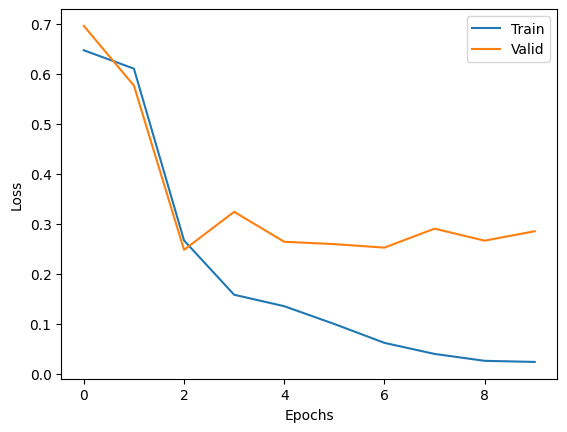

In [20]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/GridSearch/ModelImbalance5/model.pt
Classification Report:
Real - Precision: 0.9676, Recall: 0.9248, F1-Score: 0.9457
Fake - Precision: 0.8571, Recall: 0.9358, F1-Score: 0.8947
Accuracy: 0.9283582089552239


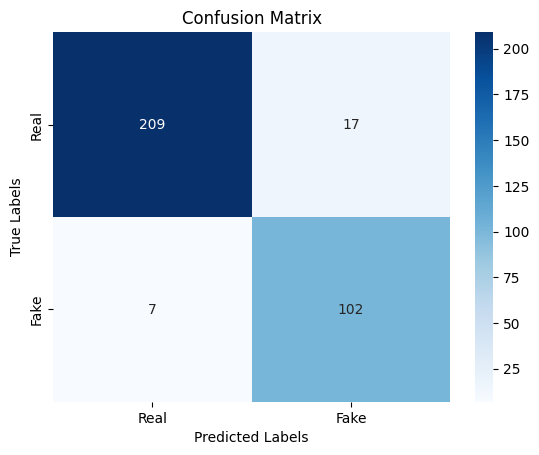

In [21]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "fake" dan label 0 menjadi "real"
    y_true = np.where(np.array(y_true) == 0, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 0, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)